In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

import logging

In [2]:
logging.getLogger().setLevel(logging.CRITICAL)

from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

In [3]:
jtplot.style('default', grid=False)
plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [4]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Au_4f' : 6.250, 'Cl_2p' : 0.891})

In [5]:
def plot_xp_regions(experiments : list, regions : list, colors : list = None, ncols : int = 3):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))
    
    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols            
            if i == len(regions) - 1:   # Set labels from last region
                li = plot_region(xp, r, ax=ax[j][k], lb=xp.name)
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title('Au_4d')
                ax[j][k].get_legend().remove()
            else:
                li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

# Analysis injections 800 mbar
40, 80 and 120 pulses

At $t_{on}$ = 50 ms and C = 1µM

## Read processed experiments

In [5]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if ('/proc' in f):
        files_new.append(f)
files = files_new[:4]
files

['/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_16_Au_crystal_FBI/proc/20191016_Au(788)_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_16_Au_crystal_FBI/proc/20191016_FBI_FBI_Ba_1uM_40pulse_50ms_Au(788).xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_17_Au_crystal/proc/20191017_FBI_FBI_Ba_1uM_120pulse_50ms_Au(788).xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_17_Au_crystal/proc/20191017_FBI_FBI_Ba_1uM_80pulse_50ms_Au(788).xy']

In [6]:
files[2], files[3] = files[3], files[2]
files

['/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_16_Au_crystal_FBI/proc/20191016_Au(788)_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_16_Au_crystal_FBI/proc/20191016_FBI_FBI_Ba_1uM_40pulse_50ms_Au(788).xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_17_Au_crystal/proc/20191017_FBI_FBI_Ba_1uM_80pulse_50ms_Au(788).xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_17_Au_crystal/proc/20191017_FBI_FBI_Ba_1uM_120pulse_50ms_Au(788).xy']

In [7]:
proc_exps = []
for f in files:
    proc_exps.append(read_processed_xp(f))

## Show individual plots

In [13]:
regions = proc_exps[0].dfx.columns.levels[0].values
regions= ['Ba_3d', 'C_1s', 'O_1s', 'overview_']

AttributeError: 'NoneType' object has no attribute 'remove'

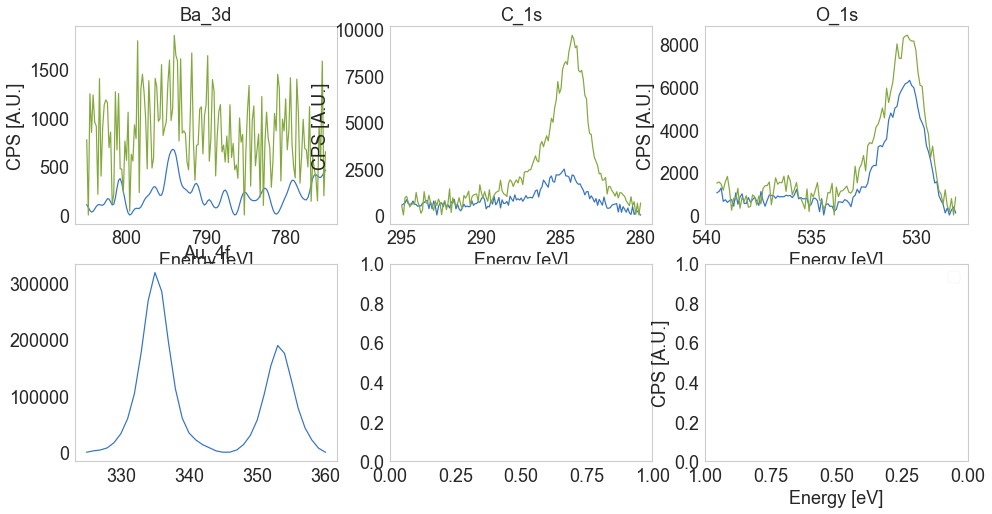

In [14]:
colors = ['b', 'g']
plot_xp_regions(proc_exps[:2], regions, colors)

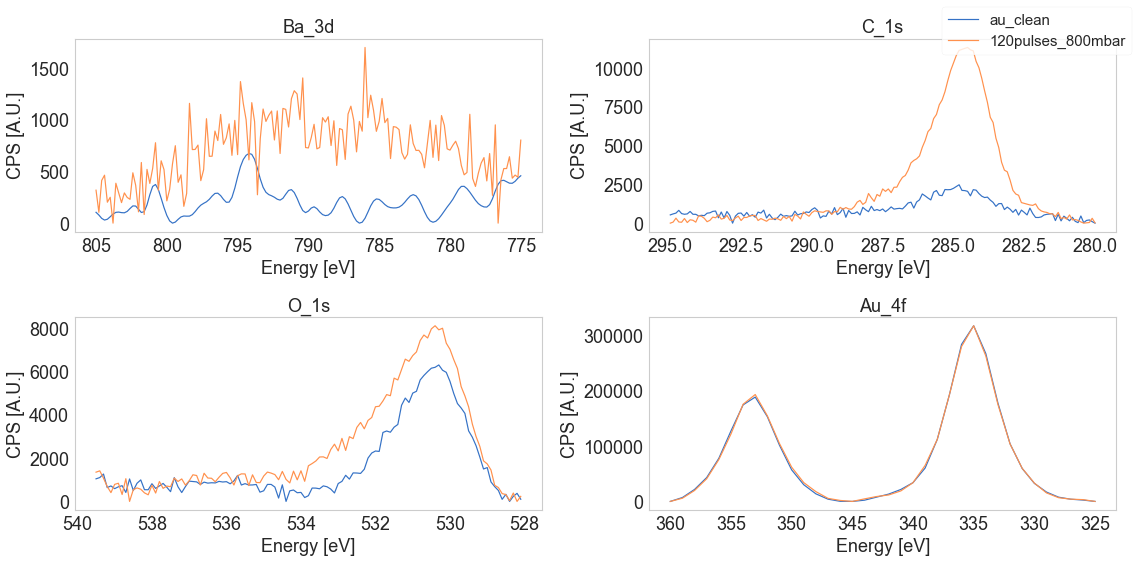

In [15]:
cols = ['b', 'y']
plot_xp_regions([proc_exps[0], proc_exps[3]], regions, cols, ncols=2)

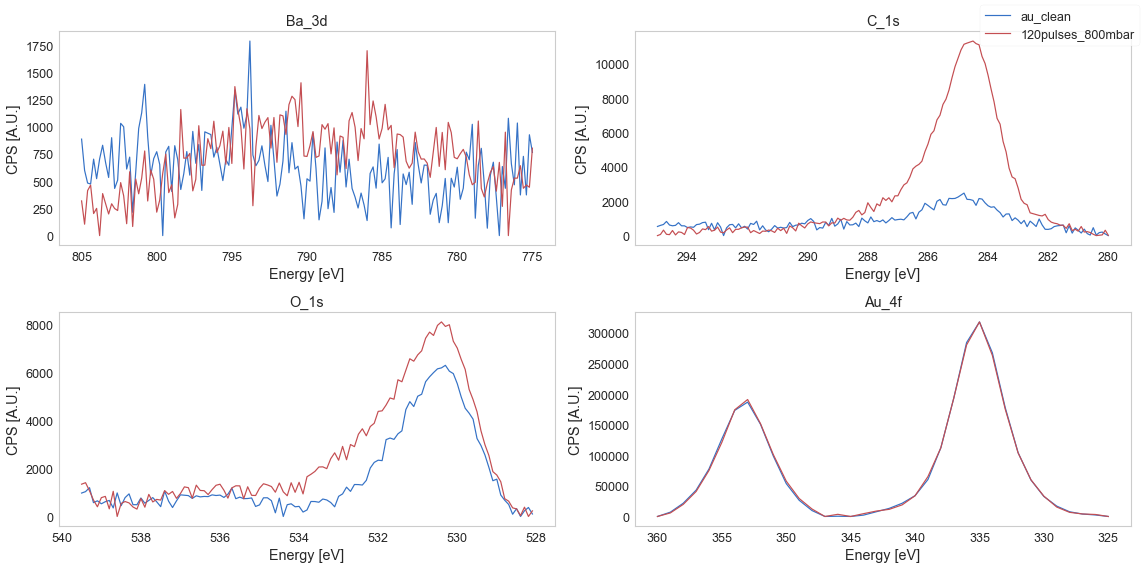

In [23]:
cols = ['b', 'r']
plot_xp_regions([proc_exps[0], proc_exps[2]], regions, cols, ncols=2)

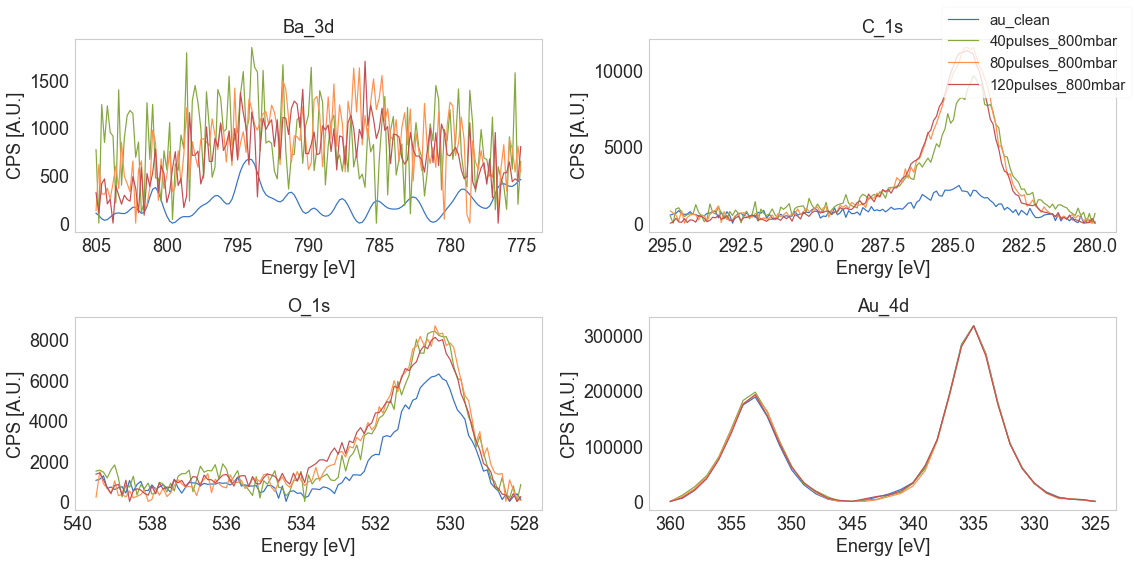

In [17]:
cols = ['b', 'g', 'y', 'r']
plot_xp_regions(proc_exps, regions, colors=cols, ncols=2)

### Only Ba 3d region

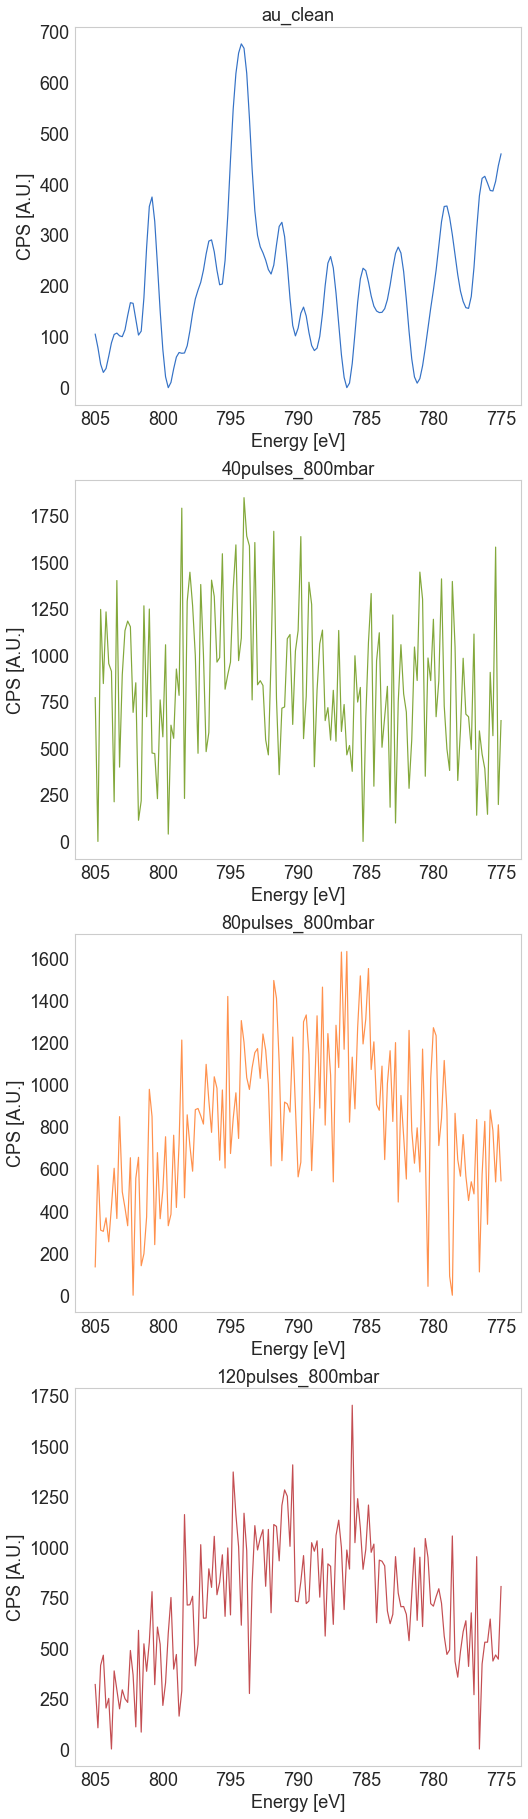

In [43]:
fig, ax = plt.subplots(4, 1, figsize=(8, 32))
for i,xp in enumerate(proc_exps):
    plot_region(xp, 'Ba_3d', ax=ax[i]).set_color(cols[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i], leg=False)
ax[i].get_legend().remove()

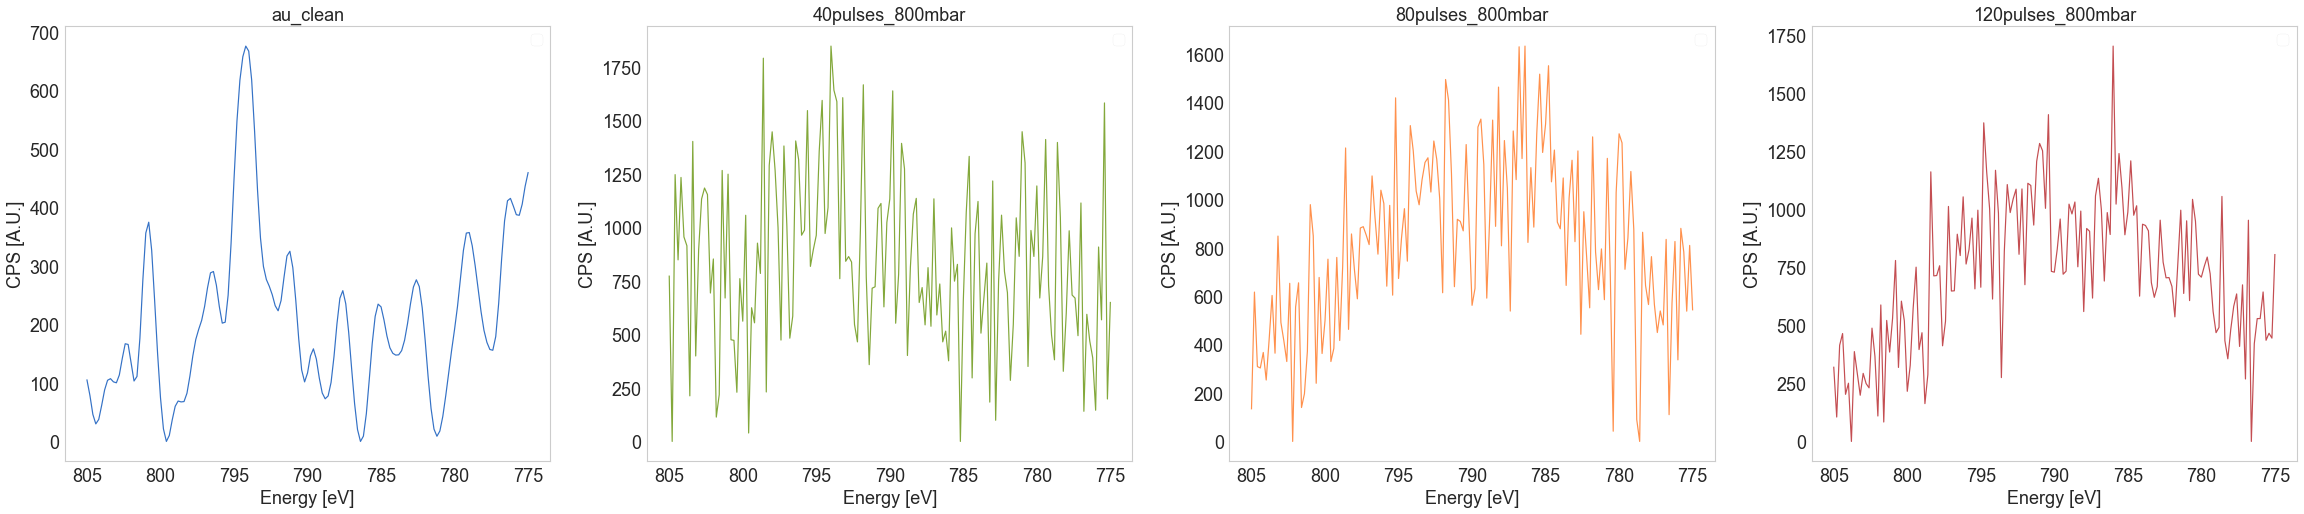

In [44]:
colors = ['b', 'g', 'y', 'r']
fig, ax = plt.subplots(1, 4, figsize=(40, 8))
for i,xp in enumerate(proc_exps):
#     if i == len(regions) - 1:   # Set labels from last region
    li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

### Normalized spectra

In [11]:
def plot_normal_regions(experiments : list, regions : list):
    """Subplots all normalized regions of a list of experiments"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for xp in experiments:
            xp_norm = normalise_dfx(xp, inplace=False)
            j, k = i//3, i%3
            if i == len(experiments):   # Set labels from last region
                plot_region(xp_norm, r, ax=ax[j][k], lb=xp_norm.name)
                ax[j][k].set_title('Au_4f')
            else:
                plot_region(xp_norm, r, ax=ax[j][k], lb='__nolabel__')
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(regions)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

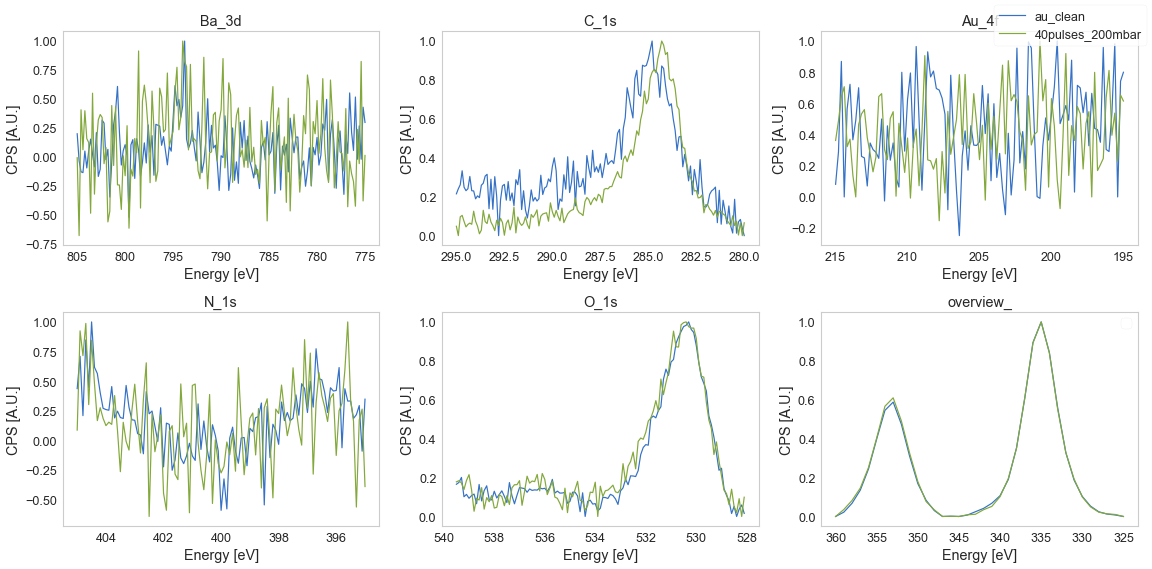

In [15]:
plot_normal_regions(proc_exps[:2], regions)

In [ ]:
plot_normal_regions(proc_exps[:2], regions)

## Integrate areas 

In [8]:
for xp in proc_exps:
    xp.area = {}

### C 1s

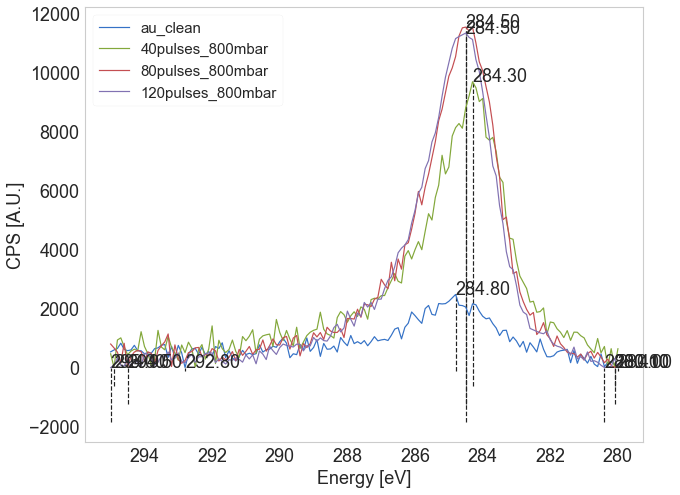

In [86]:
region = 'C_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(proc_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

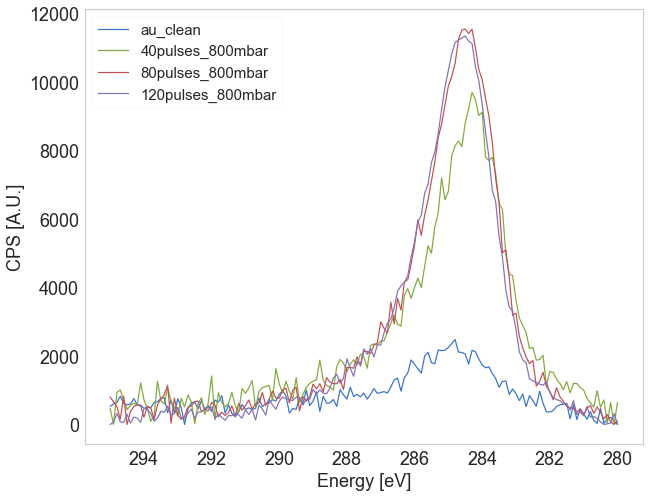

In [87]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### O 1s

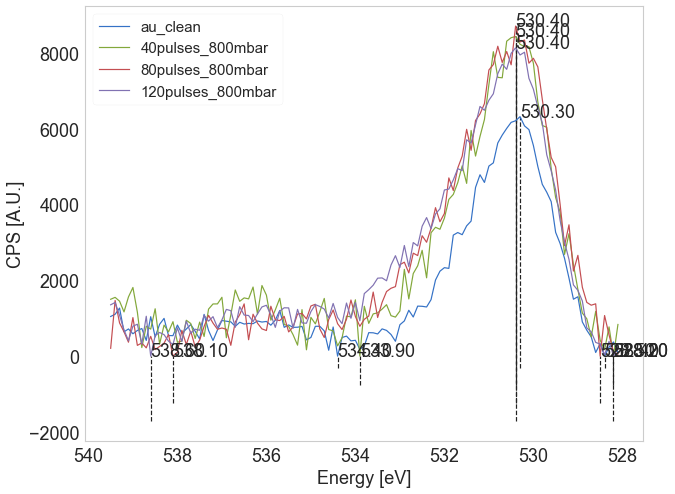

In [88]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(proc_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

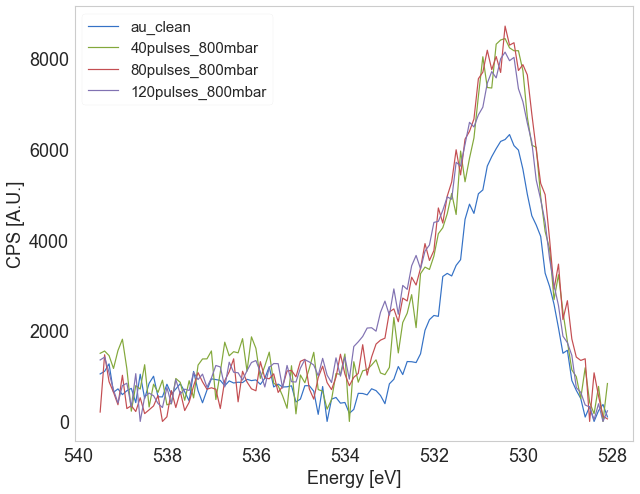

In [89]:
plt.figure(figsize=(10,8))

area_rel, names = [], []

for j,xp in enumerate(proc_exps):
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

##### Substract reference O area (this worsens stoichiometry)

In [50]:
area0 = (proc_exps[0].area['O_1s'])

for xp in proc_exps[1:]:
    area = (xp.area['O_1s'])
    xp.area.update({'O_1s' : area - area0})
    

### Ba 3d

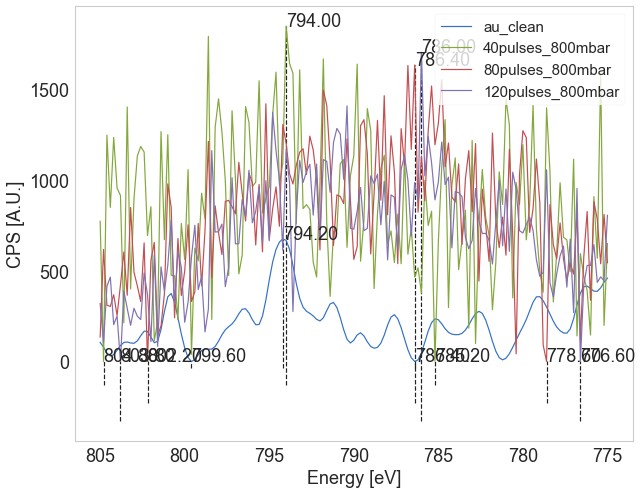

In [80]:
region = 'Ba_3d'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(proc_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

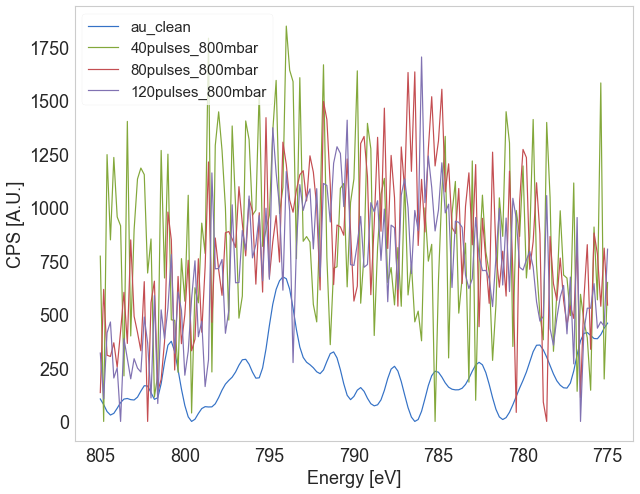

In [84]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

#### Subtract Ba from Au_clean

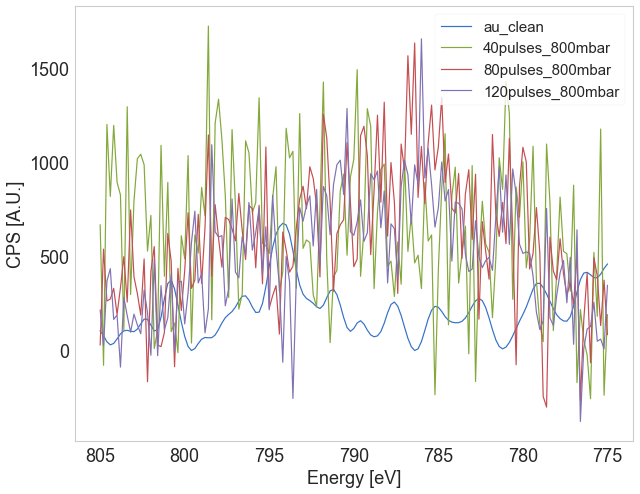

In [85]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    if j != 0: xp.dfx[region].counts -= proc_exps[0].dfx[region].counts
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### Cl 3d

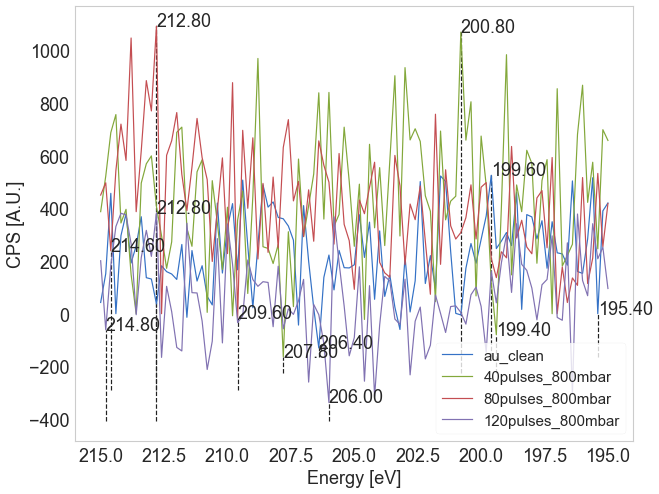

In [53]:
region = 'Cl_2p'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(proc_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

In [54]:
xp.area

{'C_1s': 120044.31615525212,
 'O_1s': 10859.098887127606,
 'Ba_3d': 1920.7140674444133}

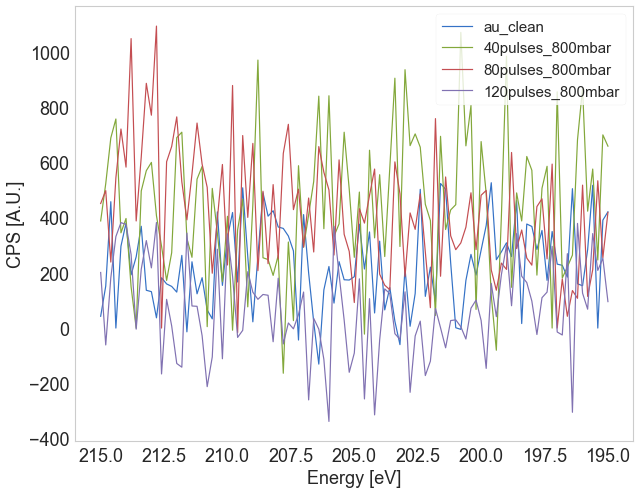

In [55]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### N 1s

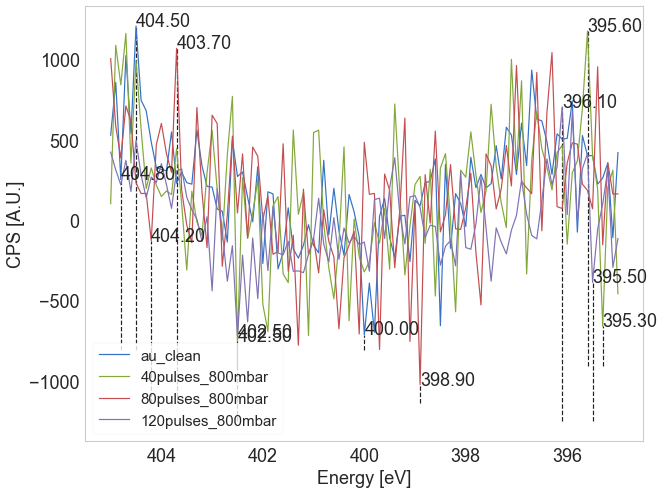

In [56]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(proc_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

In [57]:
ind

[[5, 2, 50], [94, 25, 97], [13, 8, 61], [89, 25, 95]]

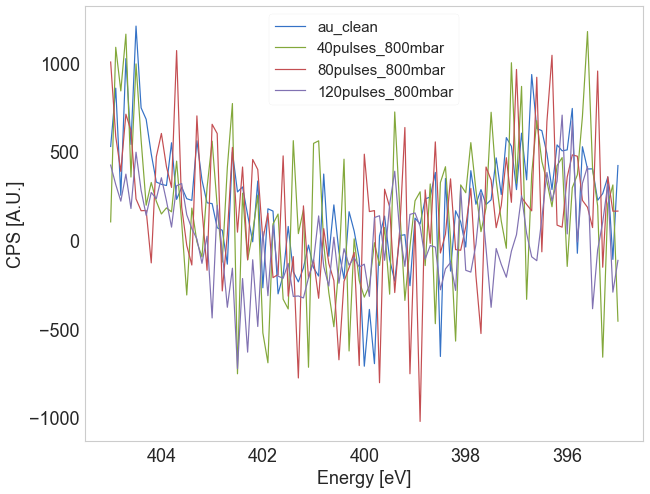

In [58]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    area = compare_areas(proc_exps[0], xp, region, lmidx=5, rmidx=95)
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

In [59]:
xp.area

{'C_1s': 120044.31615525212,
 'O_1s': 10859.098887127606,
 'Ba_3d': 1920.7140674444133,
 'Cl_2p': -120.19102190026005,
 'N_1s': -320.26133872639565}

### Au 4f

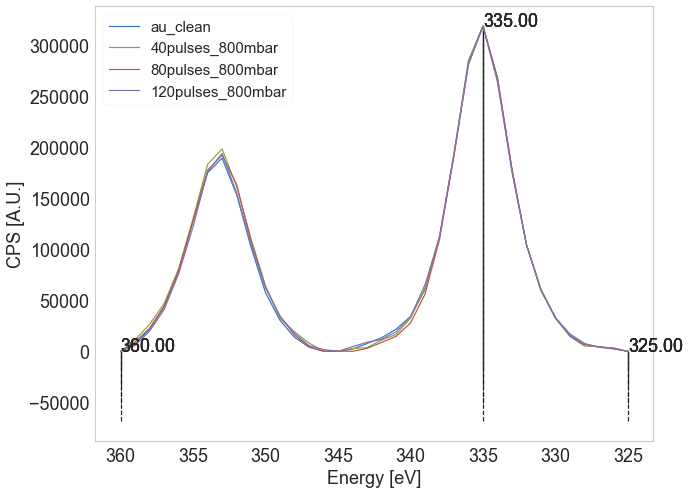

In [91]:
region = 'overview_'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(proc_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

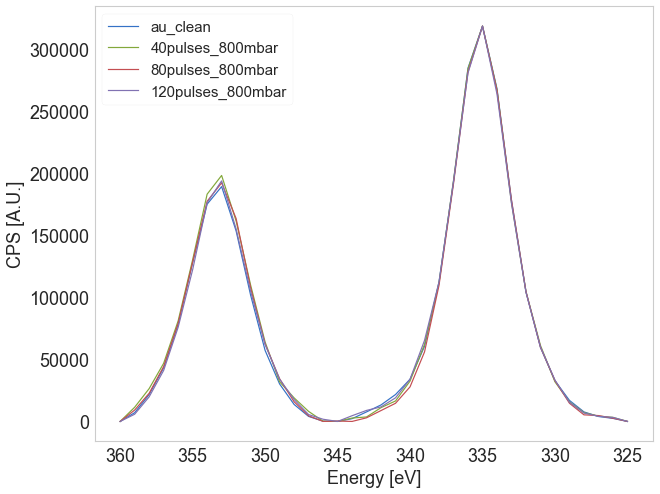

In [92]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({'Au_4f' : area[1]/asf['Au_4f']})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

## Stoichiometry 

In [93]:
num, denom = (('C_1s', 'C_1s', 'O_1s', 'C_1s'), ('O_1s', 'Au_4f', 'Ba_3d', 'Ba_3d'))
make_stoichometry_table(proc_exps,  num=num, denom=denom)

Experiment	C_/O_	C_/Au_	O_/Ba_	C_/Ba_	
au_clean	2.05	 0.10	 40.89	 83.63	 
40pulses_800mbar	3.94	 0.27	 16.82	 66.32	 
80pulses_800mbar	3.82	 0.29	 20.10	 76.79	 
120pulses_800mbar	3.73	 0.28	 23.01	 85.81	 


In [146]:
wCl = 31/13
noCl = 31/5
measure = 3.73
ratio_ba = (measure - wCl) / (noCl - wCl)

In [149]:
31/ 58
ratio_ba/0.53

0.6653225806451613

In [280]:
num, denom = (('C_1s', 'C_1s', 'O_1s', 'C_1s'), ('O_1s', 'Au_4f', 'Ba_3d', 'Ba_3d'))
make_stoichometry_table(proc_exps,  num=num, denom=denom)

Experiment	C_/O_	C_/Au_	O_/Ba_	C_/Ba_	
au_clean	2.05	 0.10	 77.66	 158.84	 
40pulses_200mbar	3.94	 0.28	 60.06	 236.80	 
120pulses_200mbar	3.73	 0.28	 63.22	 235.77	 
80pulses_200mbar	3.82	 0.29	 197.45	 754.16	 


### (With subtracted  substrate O)

In [65]:
num, denom = (('C_1s', 'C_1s', 'C_1s', 'C_1s'), ('O_1s', 'Au_4f', 'Ba_3d', 'N_1s'))
make_stoichometry_table(proc_exps,  num=num, denom=denom)

Experiment	C_/O_	C_/Au_	C_/Ba_	C_/N_	
au_clean	2.05	 0.10	 158.84	 21.91	 
40pulses_200mbar	13.11	 0.28	 236.80	 67.58	 
120pulses_200mbar	11.05	 0.28	 235.77	 -186.52	 
80pulses_200mbar	10.68	 0.29	 754.16	 105.63	 


# Analysis injections 200 mbar 

## Read processed experiments

In [18]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if ('/proc' in f) and ('350mbar' in f):
        files_new.append(f)
    if ('/proc' in f) and ('20191018' in f):
        files_new.append(f)
# files = files_new
files_new

['/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_18_Au_crystal/proc/20191018_Au(788)_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_23_FBI_Au_crystal/20191023_FBI_Ba_1uM_40pulse_50ms_Au(788)_350mbar/proc/20191023_FBI_Ba_1uM_40pulse_50ms_Au(788)_350mbar.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_23_FBI_Au_crystal/20191023_FBI_Ba_1uM_80pulse_50ms_Au(788)_350mbar/proc/20191023_FBI_Ba_1uM_80pulse_50ms_Au(788)_350mbars.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_25_FBI_Ba_1uM_120pulse_50ms_Au(788)_350mbar/proc/20191025_FBI_Ba_1uM_120pulse_50ms_Au(788)_350mbar.xy']

In [19]:
files = files_new

exps_200mbar = []
for f in files:
    exps_200mbar.append(read_processed_xp(f))

## Show individual plots

In [20]:
regions = exps_200mbar[0].dfx.columns.levels[0].values

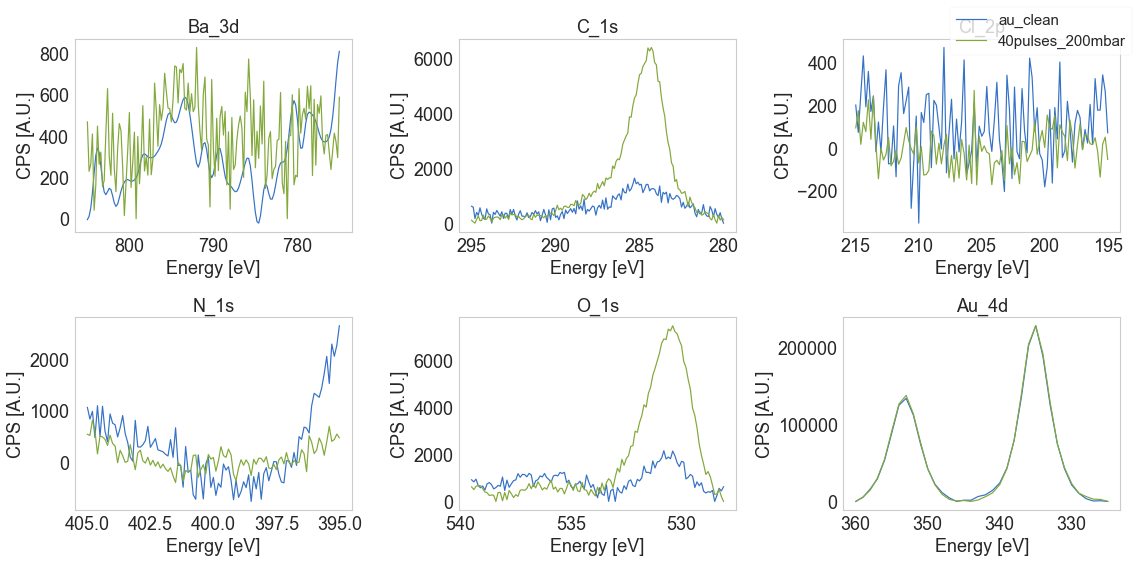

In [21]:
cols = ['b', 'g']
plot_xp_regions(exps_200mbar[:2], regions, cols)

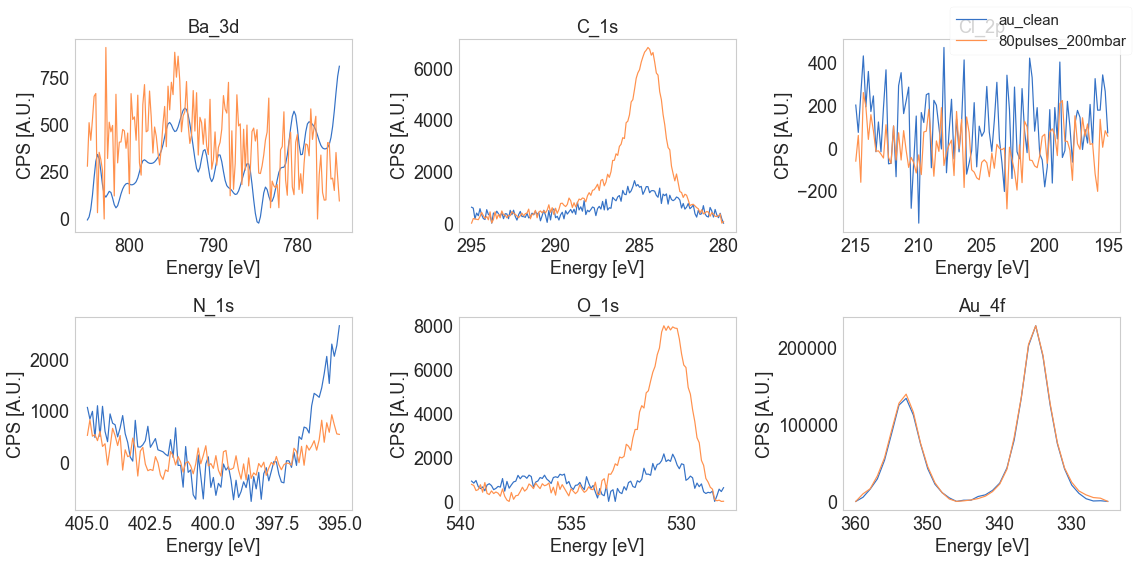

In [99]:
cols = ['b', 'y']
plot_xp_regions([exps_200mbar[0],exps_200mbar[2]], regions, cols)

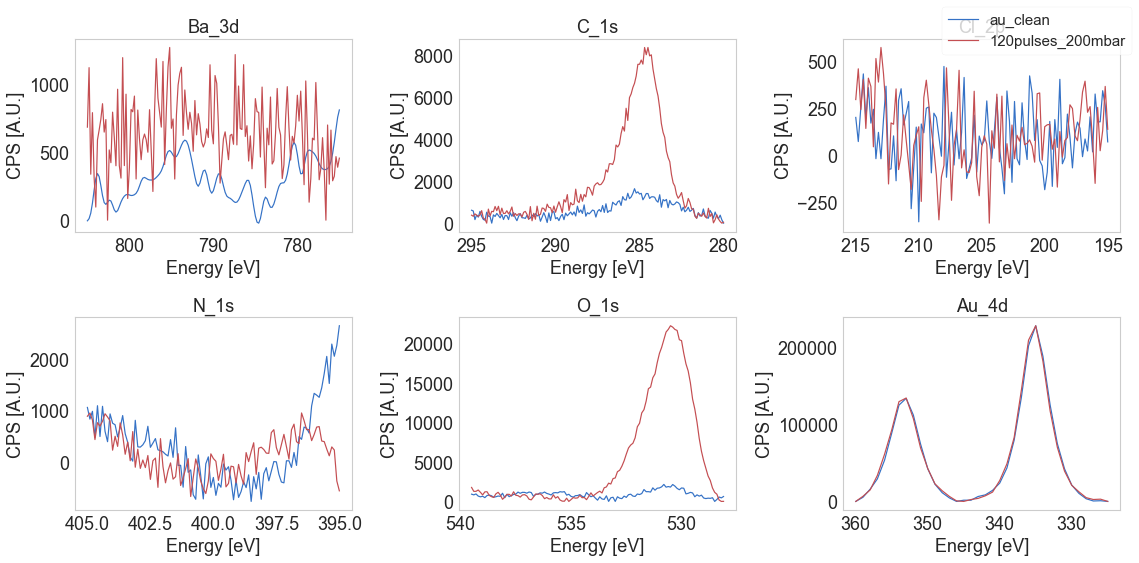

In [22]:
cols = ['b', 'r']
plot_xp_regions([exps_200mbar[0],exps_200mbar[3]], regions, cols)

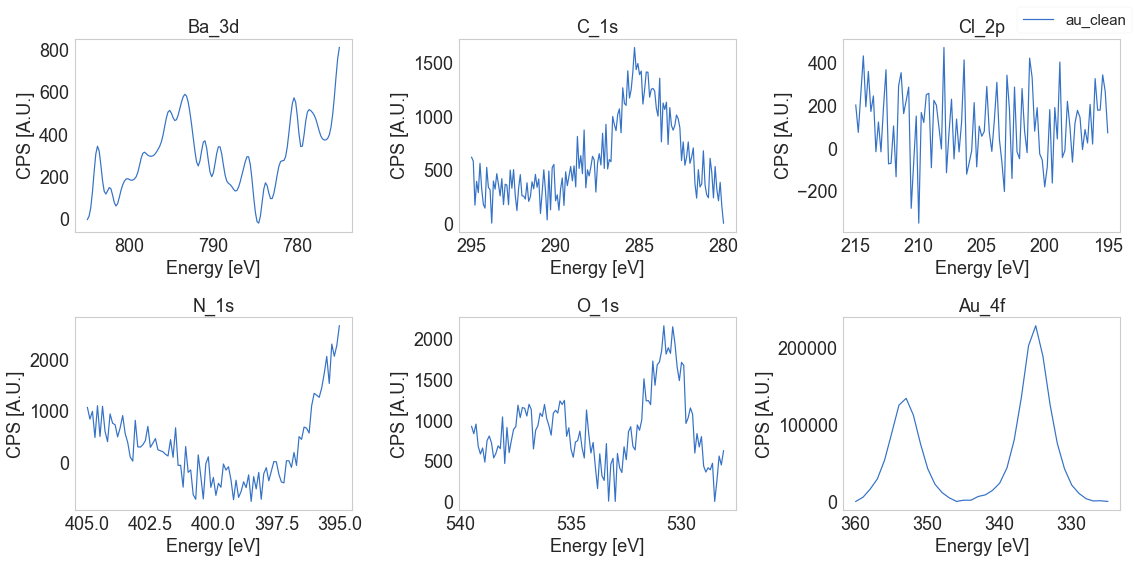

In [101]:
cols = ['b']
plot_xp_regions([exps_200mbar[0]], regions, cols)

### Show only clear areas (omit N & Cl)

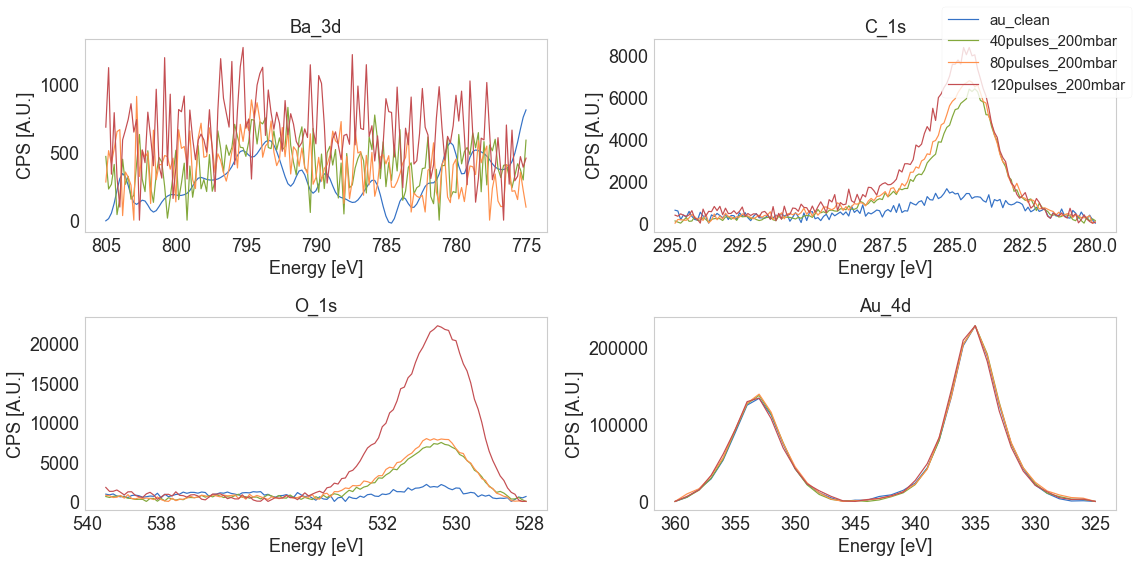

In [23]:
regions= ['Ba_3d', 'C_1s', 'O_1s', 'overview_']
cols = ['b', 'g', 'y', 'r']
plot_xp_regions(exps_200mbar, regions, colors=cols, ncols=2)

### Show Ba region

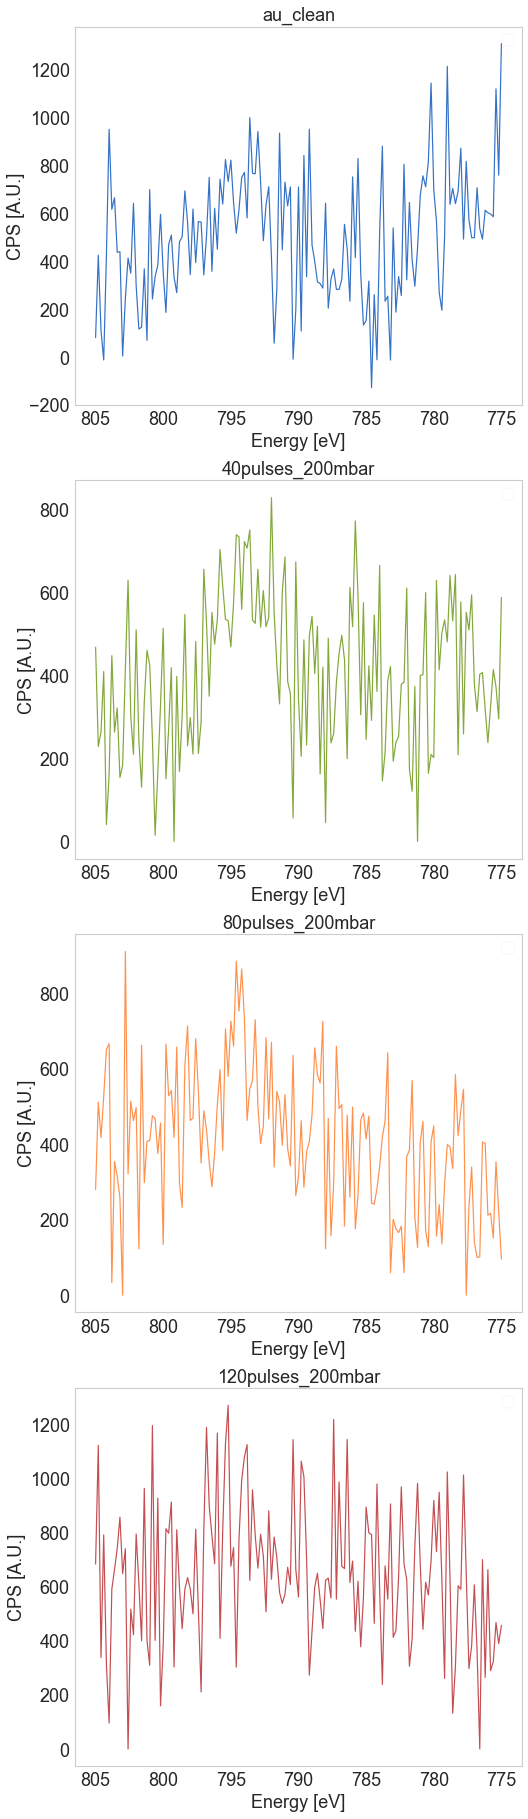

In [69]:
colors = ['b', 'g', 'y', 'r']
fig, ax = plt.subplots(4, 1, figsize=(8, 32))
for i,xp in enumerate(exps_200mbar):
#     if i == len(regions) - 1:   # Set labels from last region
    li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

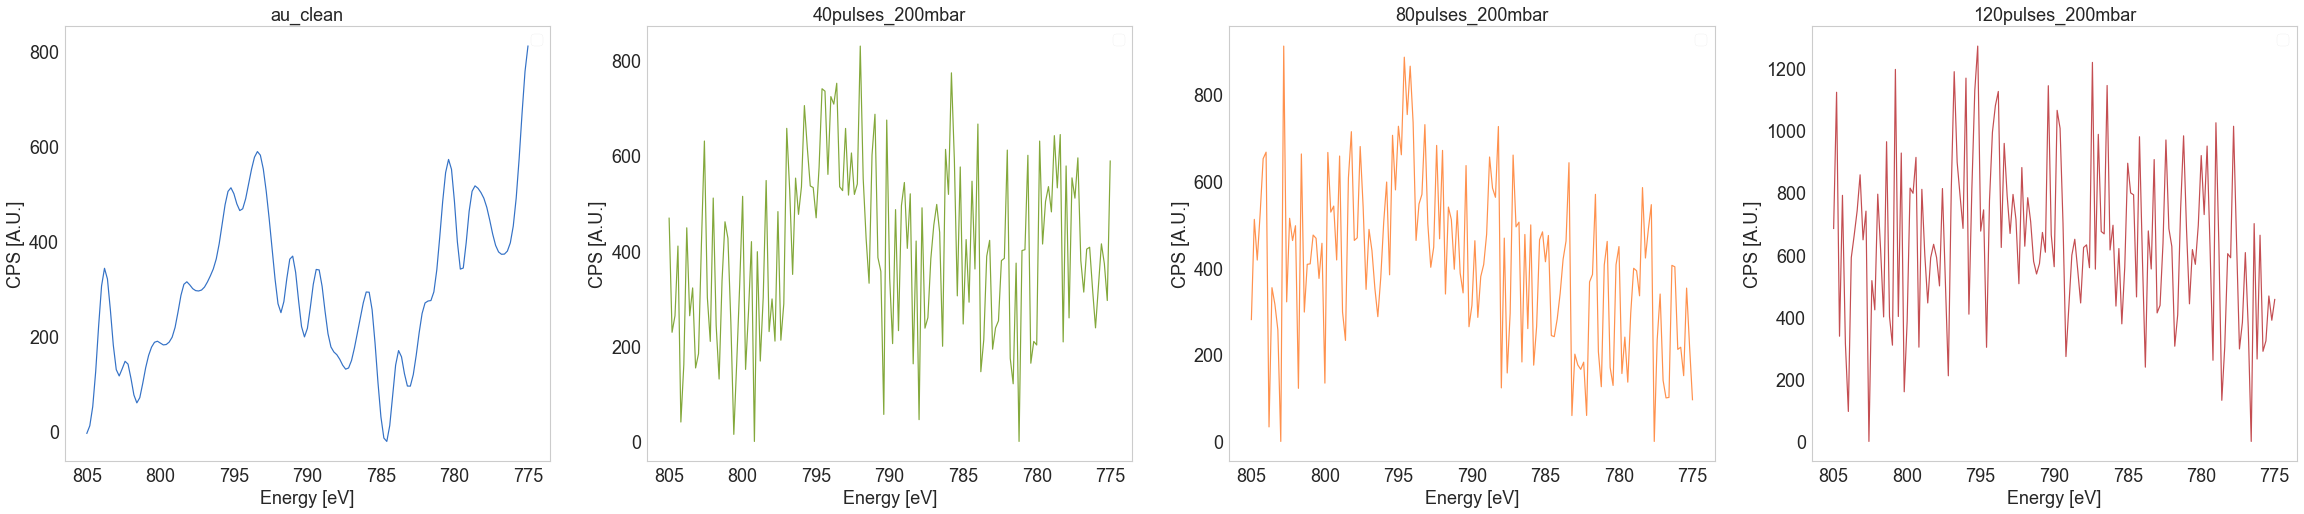

In [125]:
colors = ['b', 'g', 'y', 'r']
fig, ax = plt.subplots(1, 4, figsize=(40, 8))
for i,xp in enumerate(exps_200mbar):
#     if i == len(regions) - 1:   # Set labels from last region
    li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

## Integrate areas 

In [104]:
for xp in exps_200mbar:
    xp.area = {}

### C 1s

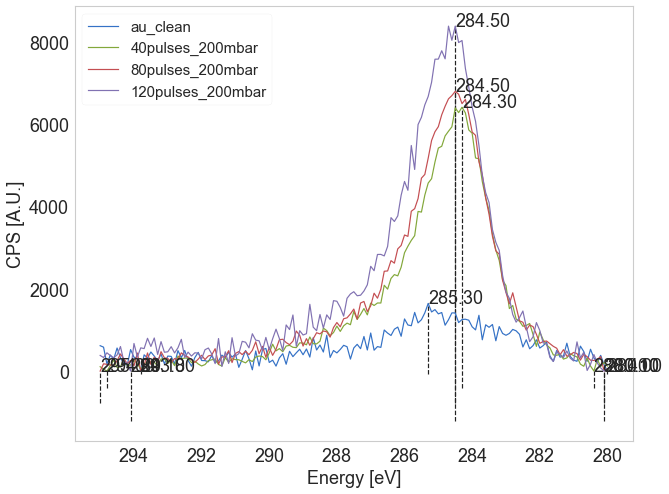

In [105]:
region = 'C_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(exps_200mbar):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

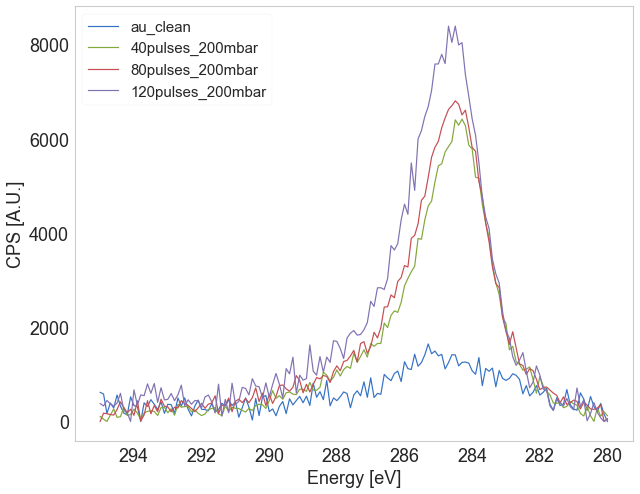

In [106]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(exps_200mbar):
    area = compare_areas(exps_200mbar[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### O 1s

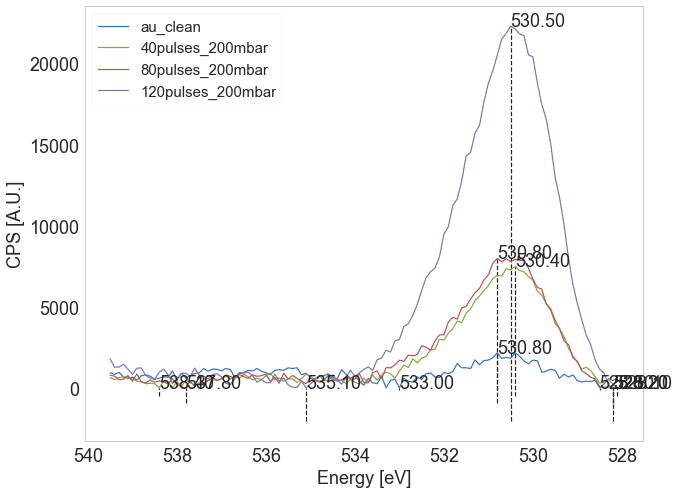

In [107]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(exps_200mbar):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

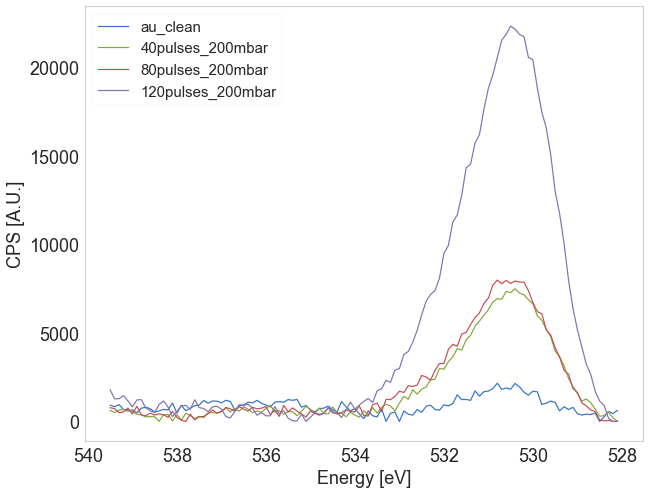

In [108]:
plt.figure(figsize=(10,8))

area_rel, names = [], []

for j,xp in enumerate(exps_200mbar):
    area = compare_areas(exps_200mbar[0], xp, region, lmidx=ind[3][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

##### Substract reference O area (this worsens stoichiometry)

In [109]:
area0 = (exps_200mbar[0].area['O_1s'])

for xp in exps_200mbar[1:]:
    area = (xp.area['O_1s'])
    xp.area.update({'O_1s' : area - area0})
    

### Ba 3d

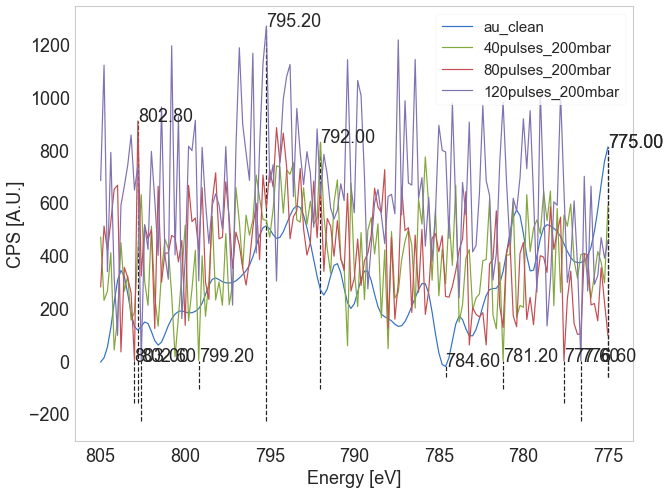

In [122]:
region = 'Ba_3d'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(exps_200mbar):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

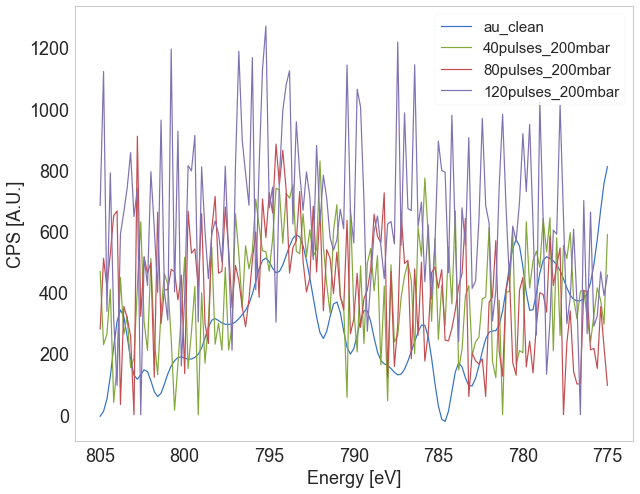

In [123]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(exps_200mbar):
    area = compare_areas(exps_200mbar[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

#### Subtract Ba from Au_clean

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


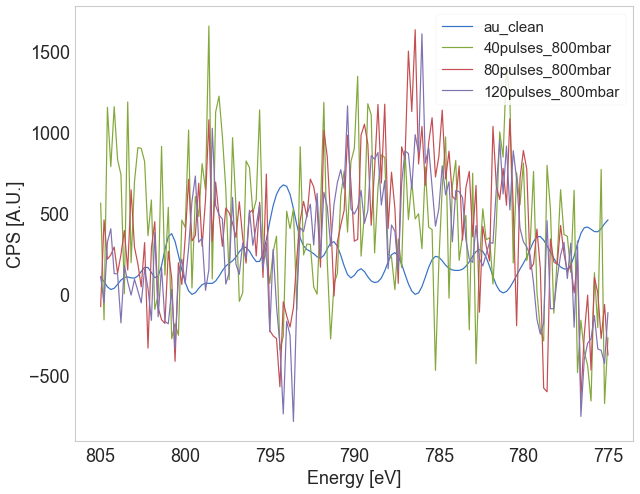

In [124]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(proc_exps):
    if j != 0: xp.dfx[region].counts -= proc_exps[0].dfx[region].counts
    area = compare_areas(proc_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### Cl 3d

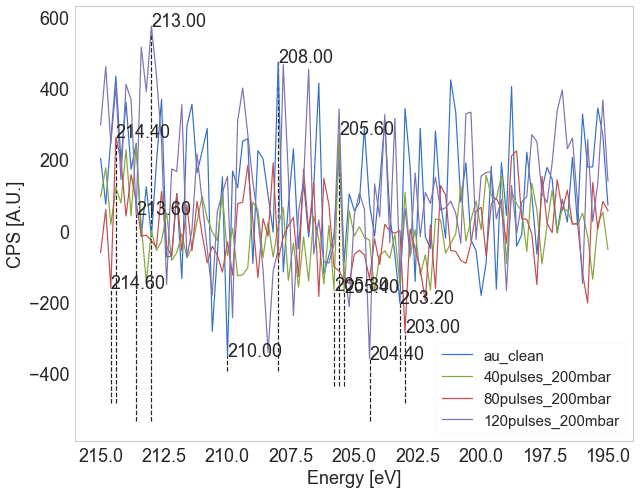

In [112]:
region = 'Cl_2p'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(exps_200mbar):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

In [113]:
xp.area

{'C_1s': 99516.45063597575,
 'O_1s': 72531.40307735441,
 'Ba_3d': 1652.959567607386}

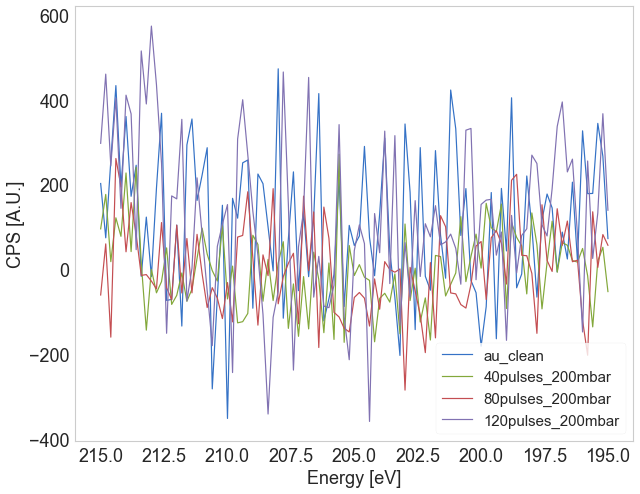

In [114]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(exps_200mbar):
    area = compare_areas(exps_200mbar[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### N 1s

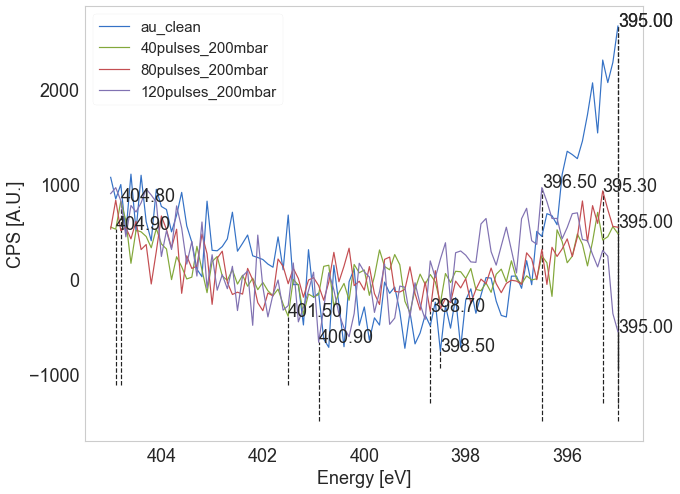

In [115]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(exps_200mbar):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

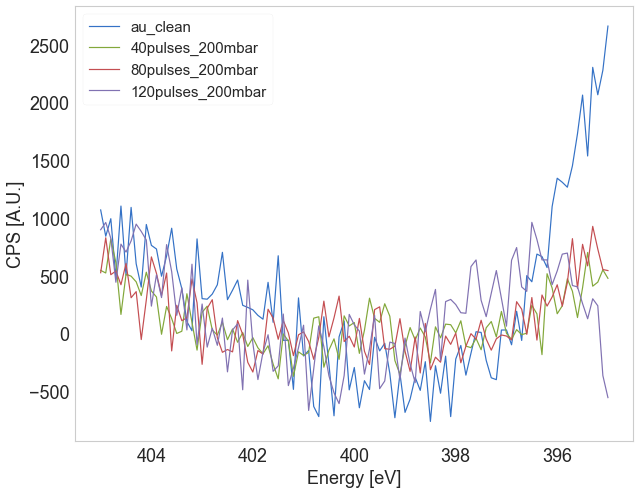

In [116]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(exps_200mbar):
    area = compare_areas(exps_200mbar[0], xp, region, lmidx=5, rmidx=95)
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

In [117]:
ind

[[100, 65, 100], [2, 1, 35], [97, 63, 100], [85, 41, 100]]

In [118]:
xp.area

{'C_1s': 99516.45063597575,
 'O_1s': 72531.40307735441,
 'Ba_3d': 1652.959567607386,
 'Cl_2p': 34.094143696992624,
 'N_1s': 2717.4297730781946}

### Au 4f

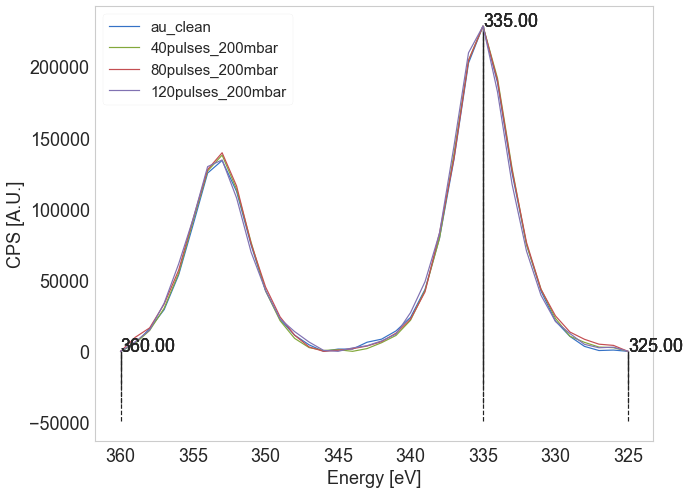

In [119]:
region = 'overview_'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(exps_200mbar):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

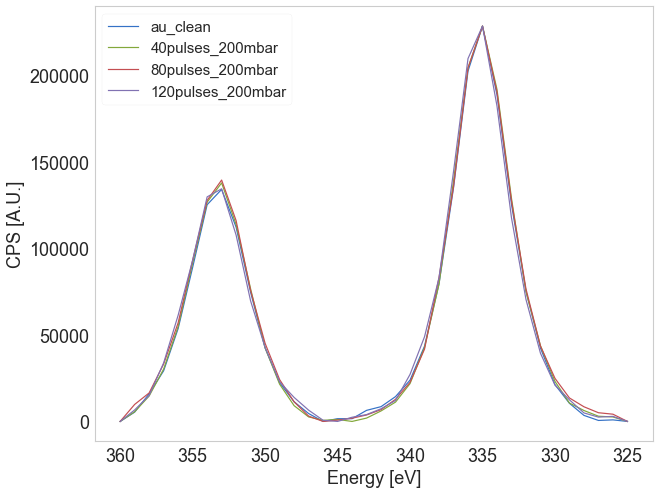

In [120]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(exps_200mbar):
    area = compare_areas(exps_200mbar[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({'Au_4f' : area[1]/asf['Au_4f']})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

## Stoichiometry

In [126]:
num, denom = (('C_1s', 'C_1s', 'O_1s', 'C_1s'), ('O_1s', 'Au_4f', 'Ba_3d', 'Ba_3d'))
make_stoichometry_table(exps_200mbar,  num=num, denom=denom)

Experiment	C_/O_	C_/Au_	O_/Ba_	C_/Ba_	
au_clean	3.43	 0.10	 13.02	 44.68	 
40pulses_200mbar	3.86	 0.23	 17.94	 69.31	 
80pulses_200mbar	3.82	 0.25	 19.80	 75.59	 
120pulses_200mbar	1.37	 0.32	 43.88	 60.21	 


# Analysis FBI-Ba++ dropcast 

## Read processed experiments

In [6]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if ('/proc' in f) and ('sputter' in f):
        files_new.append(f)
    if ('/proc' in f) and ('20191028' in f):
        files_new.append(f)
# files = files_new
files_new

['/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_28_Au_crystal_clean/proc/20191028_Au(788)_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_28_FBI_dropcast_Au_crystal/proc/20191028_FBI_dropcast_1mM_Au(788).xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_29_Au_crystal_sputter_1500ev/proc/20191029_Au(788)_sputter_1500ev.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_30_Au_crystal_sputter_2kev/proc/20191030_FBI_Ba_Au(788)_sputter_2kev.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/2019_10_31_Au_crystal_sputter_2kev/proc/20191031_FBI_Ba_Au(788)_2ndSputter_2kev.xy']

In [7]:
files = files_new

drp_exps = []
for f in files:
    drp_exps.append(read_processed_xp(f))

## Show individual regions

In [8]:
regions = drp_exps[0].dfx.columns.levels[0].values
regions

array(['Ba_3d', 'C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'overview'], dtype=object)

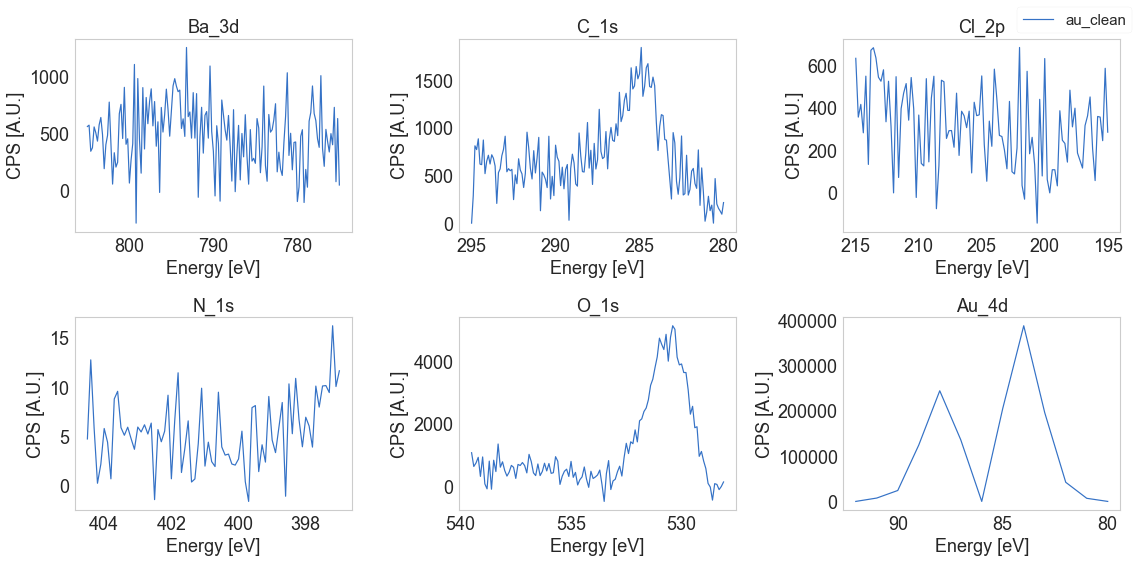

In [10]:
cols = ['b']
plot_xp_regions(drp_exps[:1], regions, cols)

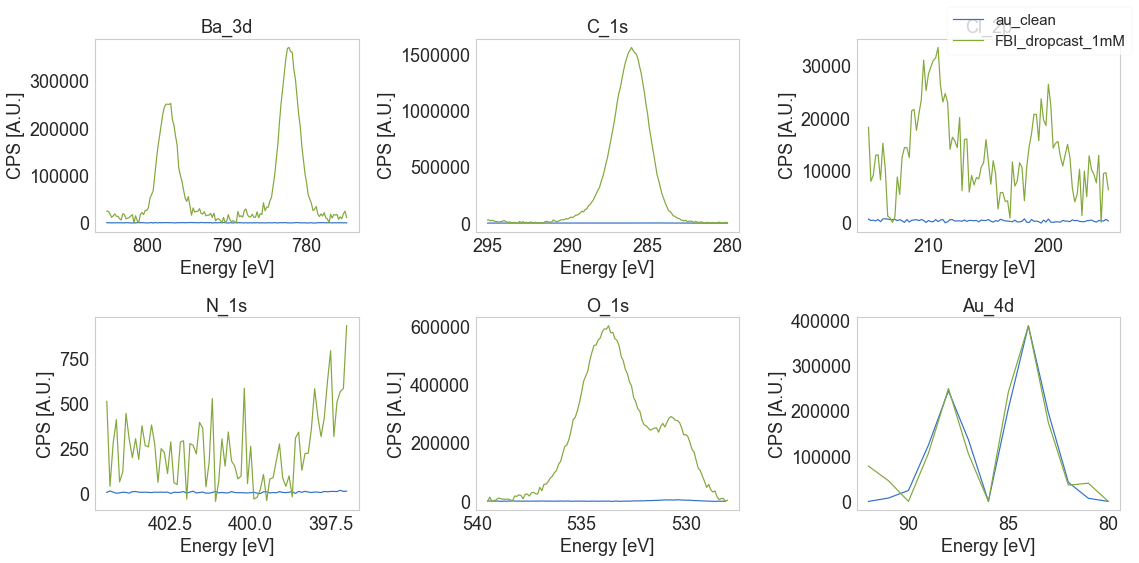

In [12]:
cols = ['b', 'g']
plot_xp_regions(drp_exps[:2], regions, cols)

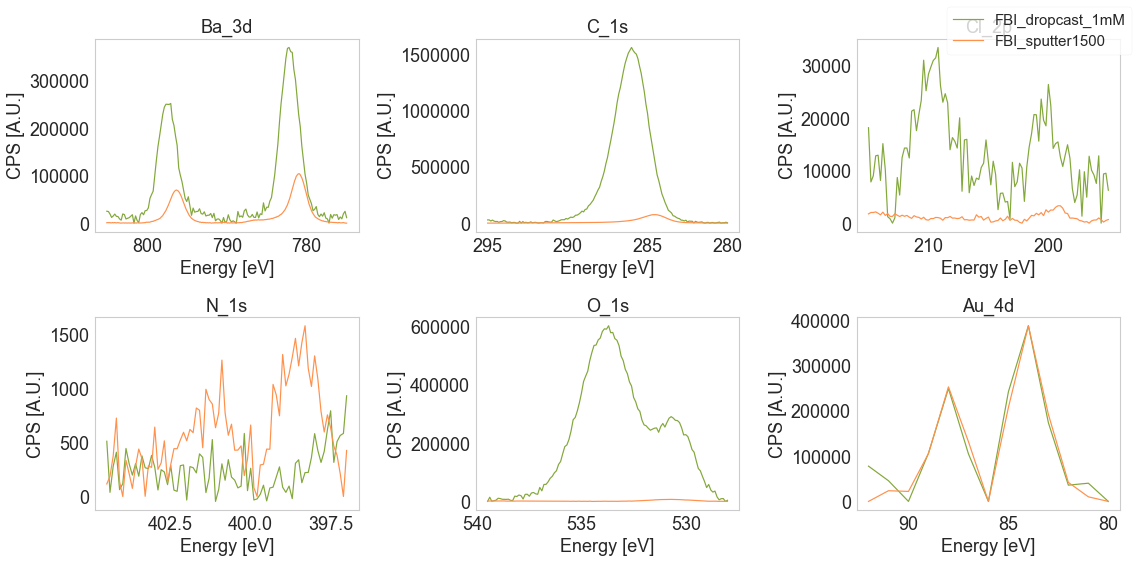

In [13]:
cols = ['g', 'y']
plot_xp_regions([drp_exps[1],drp_exps[2]], regions, cols)

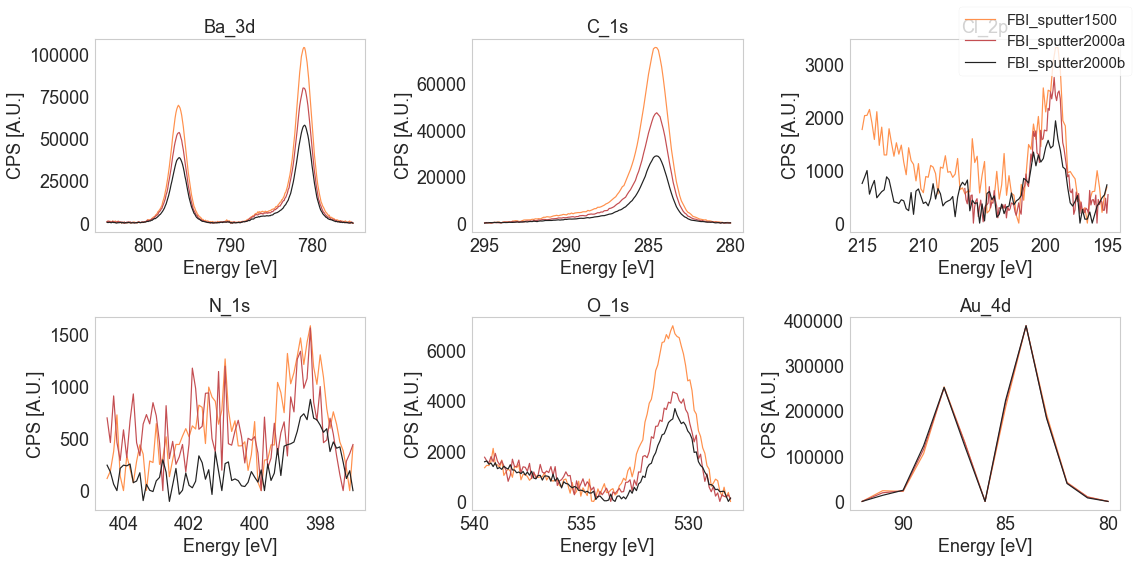

In [14]:
cols = [ 'y', 'r', 'k']
plot_xp_regions(drp_exps[2:], regions, cols)

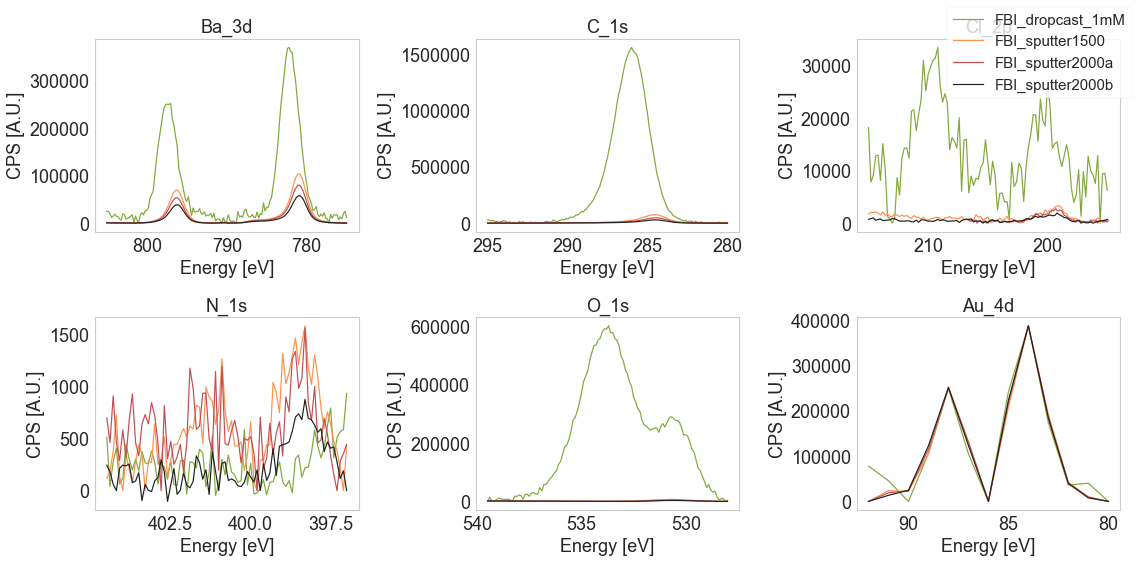

In [15]:
cols = ['g', 'y', 'r', 'k']
plot_xp_regions(drp_exps[1:], regions, cols)

## Integrate areas

In [273]:
for xp in drp_exps:
    xp.area = {}

### C 1s

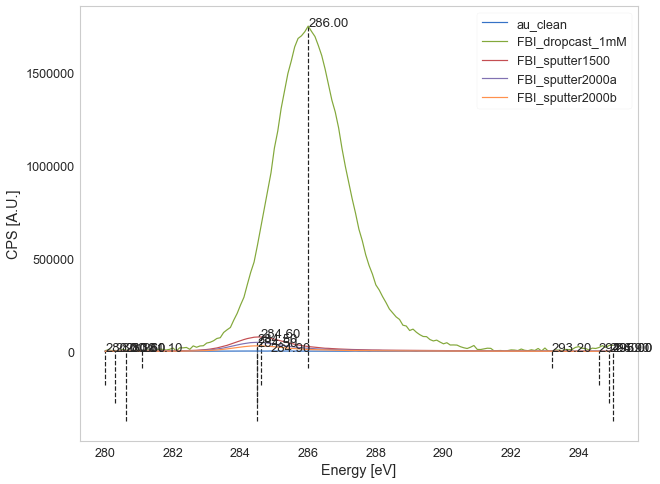

In [274]:
region = 'C_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(drp_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

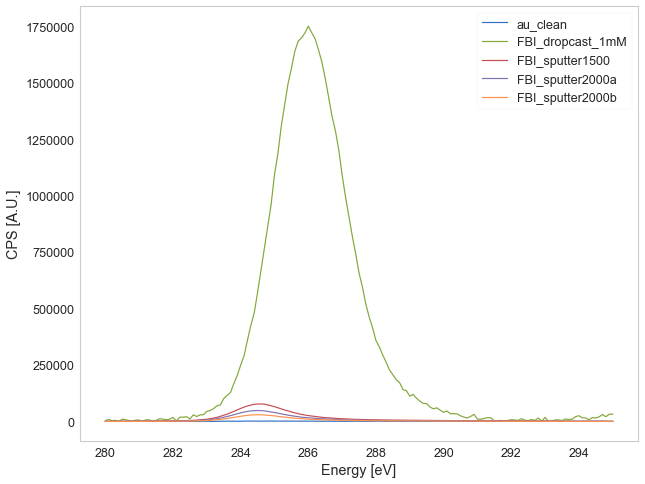

In [275]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(drp_exps):
    area = compare_areas(drp_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### O 1s

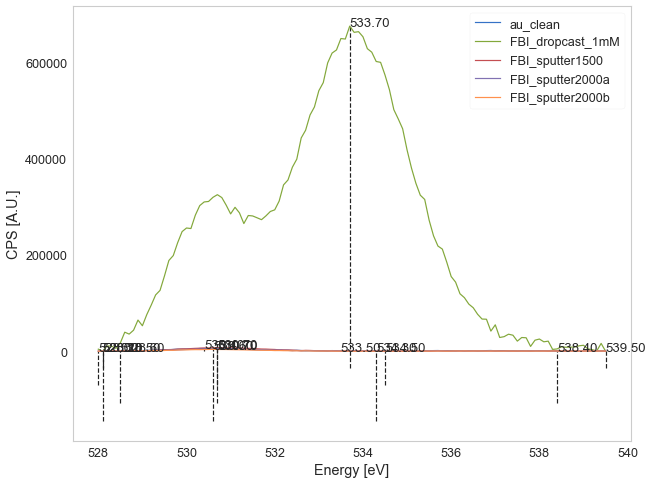

In [276]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(drp_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

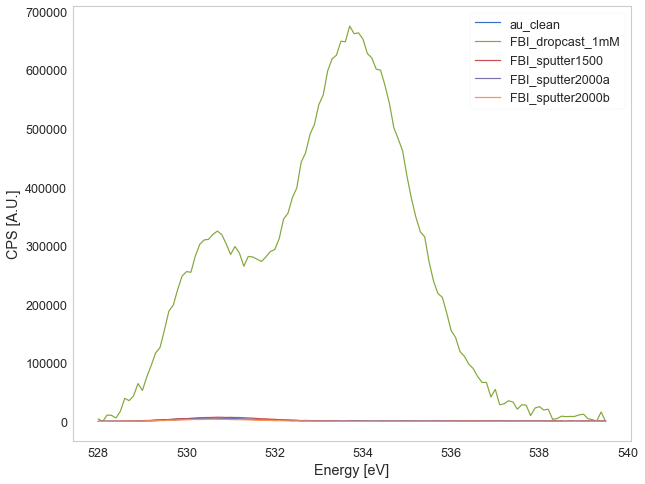

In [277]:
plt.figure(figsize=(10,8))

area_rel, names = [], []

for j,xp in enumerate(drp_exps):
    area = compare_areas(drp_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

##### Substract reference O area (this worsens stoichiometry)

In [63]:
area0 = (drp_exps[0].area['O_1s'])

for xp in drp_exps[1:]:
    area = (xp.area['O_1s'])
    xp.area.update({'O_1s' : area - area0})
    

### Ba 3d

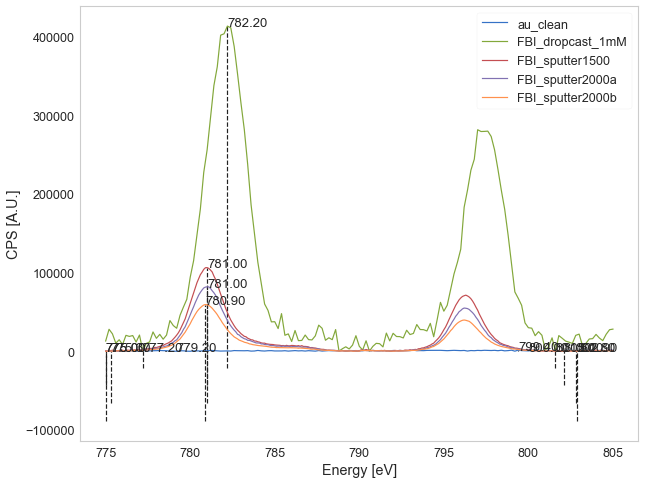

In [278]:
region = 'Ba_3d'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(drp_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

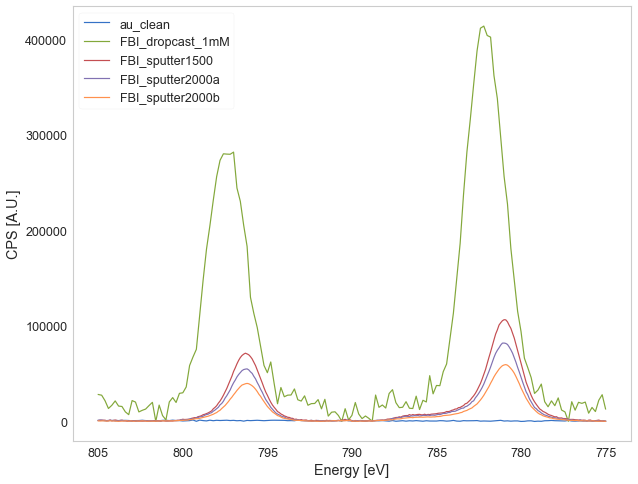

In [319]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(drp_exps):
    area = compare_areas(drp_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
plt.gca().invert_xaxis()
# inset_rel_areas(area_rel, names)

### Cl 3d

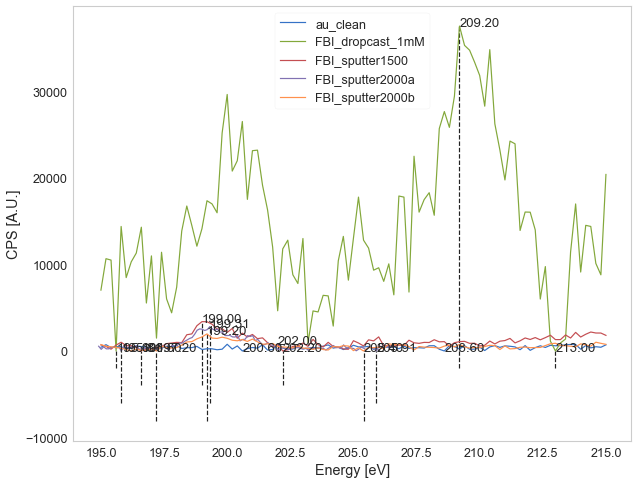

In [298]:
region = 'Cl_2p'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(drp_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

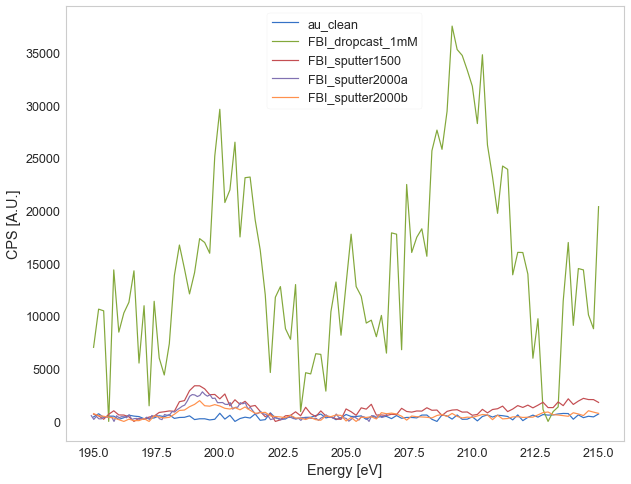

In [300]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(drp_exps):
    area = compare_areas(drp_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

### N 1s

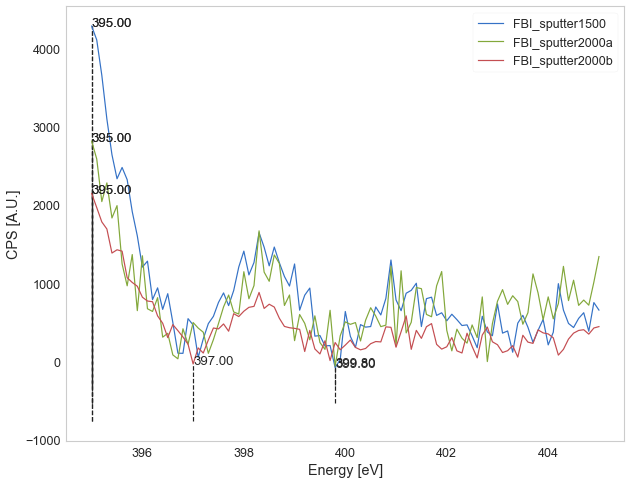

In [285]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(drp_exps[2:]):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

In [286]:
ind

[[100, 52, 100], [100, 52, 100], [100, 80, 100]]

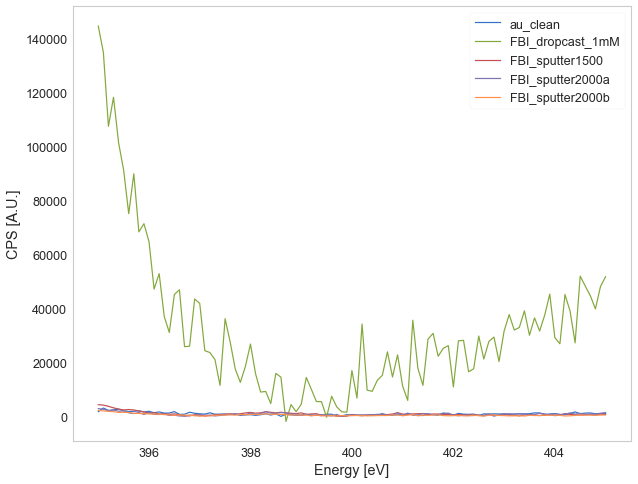

In [287]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(drp_exps):
    area = compare_areas(drp_exps[0], xp, region, lmidx=52, rmidx=80)
    area_rel.append(area[0])
    xp.area.update({region : area[1]/asf[region]})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

In [288]:
xp.area

{'C_1s': 257496.8190122871,
 'O_1s': 14997.736457652149,
 'Ba_3d': 13426.998882095006,
 'N_1s': 2479.9864804214276}

### Au 4f

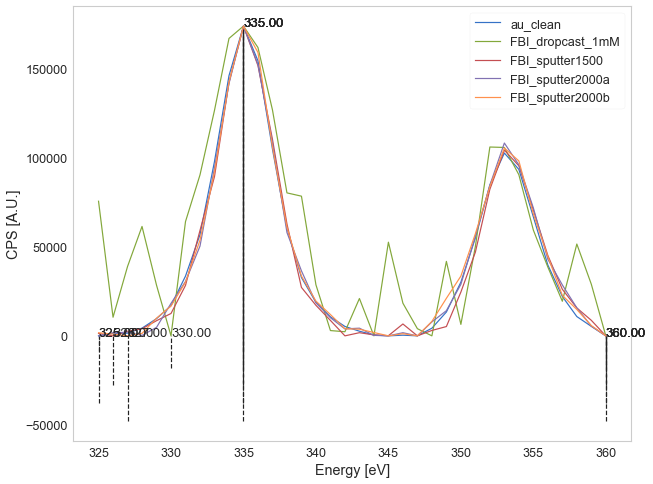

In [290]:
region = 'overview'
plt.figure(figsize=(10, 8))
ind = []
for j, xp in enumerate(drp_exps):
    ind.append(flexible_integration_limits(xp, region, doublePeak=0))
cosmetics_plot()

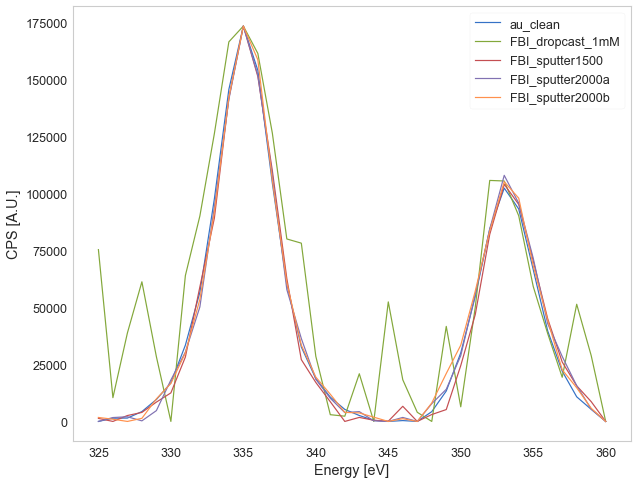

In [291]:
plt.figure(figsize=(10,8))

area_rel, names = [], []
area_in = []
for j,xp in enumerate(drp_exps):
    area = compare_areas(drp_exps[0], xp, region, lmidx=ind[1][1], rmidx=ind[1][2])
    area_rel.append(area[0])
    xp.area.update({'Au_4f' : area[1]/asf['Au_4f']})
    names.append(xp.name)
# plt.xlim(805, 760)
cosmetics_plot()
# inset_rel_areas(area_rel, names)

## Stoichiometry 

In [292]:
num, denom = (('C_1s', 'C_1s', 'O_1s', 'C_1s'), ('O_1s', 'Au_4f', 'Ba_3d', 'Ba_3d'))
make_stoichometry_table(drp_exps,  num=num, denom=denom)

Experiment	C_/O_	C_/Au_	O_/Ba_	C_/Ba_	
au_clean	1.14	 0.14	 14.34	 16.37	 
FBI_dropcast_1mM	4.13	 57.15	 12.63	 52.19	 
FBI_sputter1500	23.07	 2.95	 1.19	 27.47	 
FBI_sputter2000a	19.04	 1.82	 1.18	 22.56	 
FBI_sputter2000b	17.17	 1.12	 1.12	 19.18	 


In [338]:
31/3

10.333333333333334

In [339]:
num, denom = (('C_1s', 'Ba_3d', 'N_1s', 'Cl_2p', 'O_1s'), ('N_1s', 'Au_4f', 'Ba_3d', 'Ba_3d', 'Cl_2p'))
make_stoichometry_table(drp_exps,  num=num, denom=denom)

Experiment	C_/N_	Ba_/Au_	N_/Ba_	Cl_/Ba_	O_/Cl_	
au_clean	10.11	 0.01	 1.95	 4.79	 3.60	 
FBI_dropcast_1mM	232.20	 0.50	 0.50	 2.16	 12.94	 
FBI_sputter1500	133.60	 0.09	 0.25	 1.10	 1.32	 
FBI_sputter2000a	107.73	 0.07	 0.25	 0.58	 2.45	 
FBI_sputter2000b	103.83	 0.05	 0.23	 1.04	 1.31	 


# Compare some Barium and Nitrogen experiments 

## Ba 3d

In [ ]:
region = 'Ba_3d'

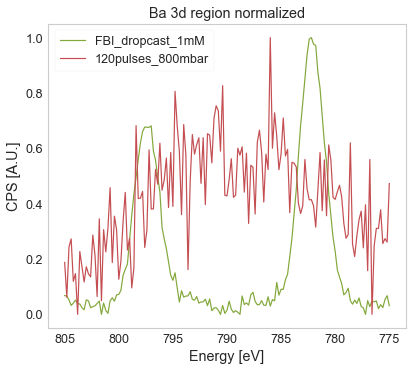

In [320]:
plot_region(normalise_dfx(drp_exps[1]), region, lb=drp_exps[1].name).set_color('g')
plot_region(normalise_dfx(proc_exps[2]), region, lb=proc_exps[2].name).set_color('r')
plt.gca().legend()
plt.title('Ba 3d region normalized')
plt.gca().invert_xaxis()

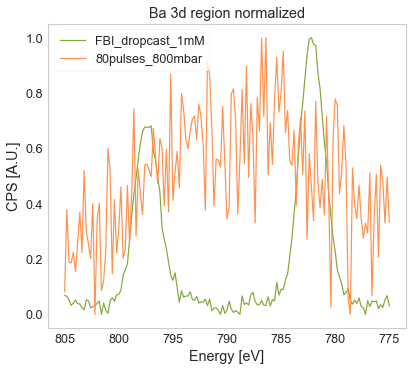

In [321]:
plot_region(normalise_dfx(drp_exps[1]), region, lb=drp_exps[1].name).set_color('g')
plot_region(normalise_dfx(proc_exps[3]), region, lb=proc_exps[3].name).set_color('y')
plt.gca().legend()
plt.title('Ba 3d region normalized')
plt.gca().invert_xaxis()

Text(0.5, 1.0, 'Ba 3d region normalized')

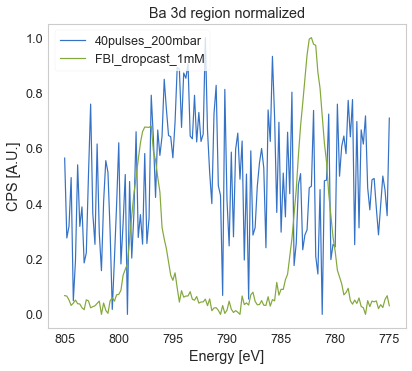

In [322]:
plot_region(normalise_dfx(exps_200mbar[1]), region, lb=exps_200mbar[1].name).set_color('b')
plot_region(normalise_dfx(drp_exps[1]), region, lb=drp_exps[1].name).set_color('g')

plt.gca().legend()
plt.gca().invert_xaxis()
plt.title('Ba 3d region normalized')

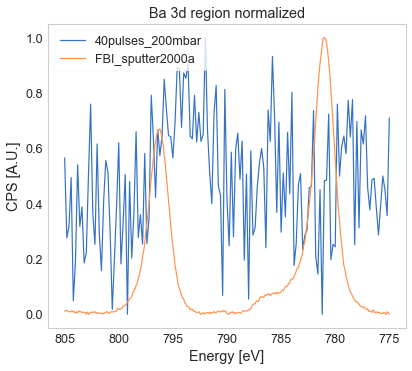

In [323]:
plot_region(normalise_dfx(exps_200mbar[1]), region, lb=exps_200mbar[1].name).set_color('b')
plot_region(normalise_dfx(drp_exps[3]), region, lb=drp_exps[3].name).set_color('y')

plt.gca().legend()
plt.title('Ba 3d region normalized')
plt.gca().invert_xaxis()

## N 1s

In [17]:
region = 'N_1s'

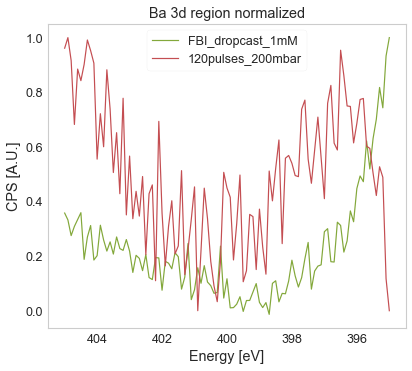

In [326]:
plot_region(normalise_dfx(drp_exps[1]), region, lb=drp_exps[1].name).set_color('g')
plot_region(normalise_dfx(exps_200mbar[3]), region, lb=exps_200mbar[3].name).set_color('r')
plt.gca().legend()
plt.title('Ba 3d region normalized')
plt.gca().invert_xaxis()

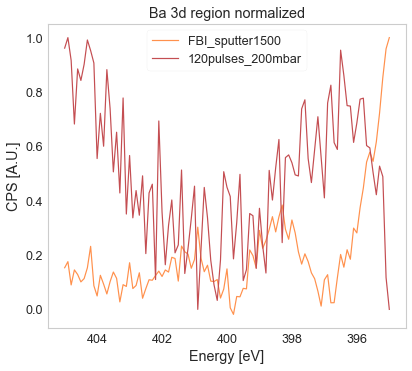

In [327]:
plot_region(normalise_dfx(drp_exps[2]), region, lb=drp_exps[2].name).set_color('y')
plot_region(normalise_dfx(exps_200mbar[3]), region, lb=exps_200mbar[3].name).set_color('r')
plt.gca().legend()
plt.title('Ba 3d region normalized')
plt.gca().invert_xaxis()

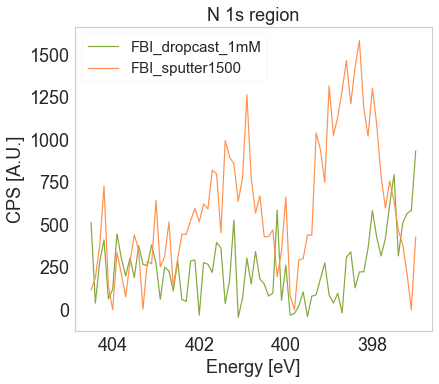

In [25]:
plot_region(drp_exps[1], region, lb=drp_exps[1].name).set_color('g')
plot_region(drp_exps[2], region, lb=drp_exps[2].name).set_color('y')
plt.gca().legend()
plt.title('N 1s region')
plt.gca().invert_xaxis()

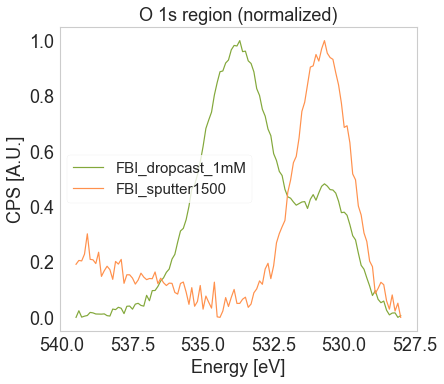

In [29]:
region = 'O_1s'
plot_region(normalise_dfx(drp_exps[1]), region, lb=drp_exps[1].name).set_color('g')
plot_region(normalise_dfx(drp_exps[2]), region, lb=drp_exps[2].name).set_color('y')
plt.gca().legend()
plt.title('O 1s region (normalized)')
plt.gca().invert_xaxis()

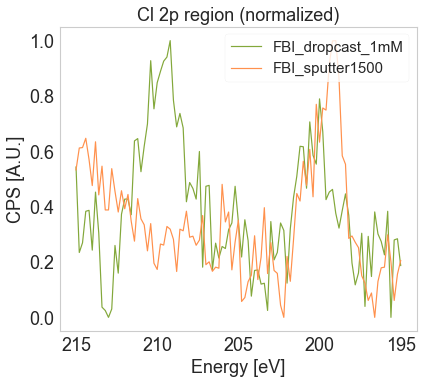

In [30]:
region = 'Cl_2p'
plot_region(normalise_dfx(drp_exps[1]), region, lb=drp_exps[1].name).set_color('g')
plot_region(normalise_dfx(drp_exps[2]), region, lb=drp_exps[2].name).set_color('y')
plt.gca().legend()
plt.title('Cl 2p region (normalized)')
plt.gca().invert_xaxis()